# Sentiment Analysis - Twitter

In [1]:
from __future__ import print_function
%matplotlib inline

from IPython.display import Image, display
from io import BytesIO
import matplotlib.pyplot as plt

#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

#import numpy as numpy
import random
#import pickle
from collections import Counter
import codecs
import tensorflow as tf
import np
import time

import os
from os.path import join, exists

import pandas as pd
import pydot_ng as pydot
import graphviz
from ggplot import *

from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Dropout, Flatten, LSTM
from keras.optimizers import RMSprop, Adam, SGD, Adagrad

#nltk.download('punkt')
#nltk.download('wordnet')
#totalLinesToRead = 100
#lemmatizer = WordNetLemmatizer()

/usr/local/lib/python2.7/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python2.7/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# Data load

The first step when building machine learning model is getting your data into the proper form to feed into the model. 


In [2]:
with open('./data/twitter-train-pos', 'r') as f:
    positive_train_txt = f.read()
with open('./data/twitter-train-neg', 'r') as f:
    negative_train_txt = f.read()

## Glove
Let's assume we will say to all data positive.


In [3]:
data_folder = './datasets'
glove = 'glove.6B'
glove_filename = glove + '.zip'
glove_url = 'http://nlp.stanford.edu/data/' + glove_filename
embedding_dim = 300
glove_loc = join(data_folder, glove_filename)

if not exists(glove_loc):
    print('Download %s' % glove_filename)
    get_file(glove_filename, glove_url, cache_dir='.', extract=True)

glove_filename = os.path.join(data_folder, glove + '.' + str(embedding_dim) + 'd.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Extract ./datasets/glove.6B.300d.txt
Embeddings size: 400000


In [4]:
from string import punctuation

def get_reviews(text):
    #all_text = ''.join([c for c in text if c not in punctuation])
    reviews = text.split('\n')
    return reviews # TAKE first 1000 to make it fast

positive_train = get_reviews(positive_train_txt)
negative_train = get_reviews(negative_train_txt)

pos_len = len(positive_train)
neg_len = len(negative_train)

print("The positive data size: {}".format(pos_len))
print("The negative data size: {}".format(neg_len))

print("Basic/Benchmark Accuracy: " + str(float(pos_len) / (pos_len + neg_len)))

positive_label = np.full((pos_len, 2), [1, 0])
negative_label = np.full((neg_len, 2), [0, 1])

train = np.concatenate((positive_train, negative_train), axis=0)
labels = np.concatenate((positive_label, negative_label), axis=0)

# shuffle
c = np.c_[train.reshape(len(train), -1), labels.reshape(len(labels), -1)]
np.random.shuffle(c)

train = c[:, :train.size//len(train)].reshape(train.shape)
labels = c[:, train.size//len(train):].reshape(labels.shape)

del c
del positive_label
del negative_label
del positive_train_txt
del negative_train_txt

The positive data size: 302585
The negative data size: 294845
Basic/Benchmark Accuracy: 0.506477746347


In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)
train_ints = tokenizer.texts_to_sequences(train)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 348605 unique tokens.


In [6]:
from collections import defaultdict
NUM_WORDS = len(embeddings)
words_len = min(NUM_WORDS, len(word_index))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
        
del embeddings

In [7]:
print('Null word embeddings: %d' % (np.sum(np.sum(word_embedding_matrix, axis=1) == 0) - 1))
print('Found %d' % k)
print('Total: %d' % len(word_embedding_matrix))

Null word embeddings: -1
Found 73069
Total: 348606


In [8]:
seq_len = 15
features = sequence.pad_sequences(train_ints, maxlen = seq_len)

Couple issues here. We seem to have one review with zero length. And, the maximum review length is way too many steps for our RNN. Let's truncate to 200 steps. For reviews shorter than 200, we'll pad with 0s. For reviews longer than 200, we can truncate them to the first 200 characters.

Turns out its the final review that has zero length. But that might not always be the case, so let's make it more general.


# Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets. Do not foget to shuffle it.

In [9]:
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

In [10]:
batch_size = 20

model = load_model('model_15_embedded_drop_0.1_twitter.h5')
    
score, acc = model.evaluate(test_x, test_y,
                                batch_size=batch_size)
print('  Test score:', score)
print('  Test accuracy:', acc)

59743/59743 [==============================] - 25s 412us/step
  Test score: 0.521895174845
  Test accuracy: 0.744028589318


In [14]:
classes = model.predict(test_x, batch_size=20)
print(classes)

[[ 0.48927894  0.51072341]
 [ 0.04396183  0.95604962]
 [ 0.2132922   0.78669429]
 ..., 
 [ 0.1207424   0.8792634 ]
 [ 0.2262738   0.77370954]
 [ 0.47910404  0.52091426]]


In [27]:
predicted = np.argmax(classes, axis=1)
real = np.argmax(test_y, axis=1)

#print(predicted)
#print(real)

pos = 0
neg = 0

for i in xrange(len(predicted)):
    if predicted[i] == real[i]:
        if predicted[i] == 1:
            pos += 1
        else:
            neg += 1
            
print("positive matched " + str(pos))
print("negative matched " + str(neg))

#(predicted == real).all()

len(classes)

total_pos = 0
total_neg = 0

for i in xrange(len(predicted)):
    if predicted[i] == 1:
        total_pos += 1
    else:
        total_neg += 1
        
print("positive total " + str(total_pos))
print("negative total " + str(total_neg))


[1 1 1 ..., 1 1 1]
[1 1 1 ..., 1 1 0]
positive matched 22187
negative matched 22263
positive total 30083
negative total 29660


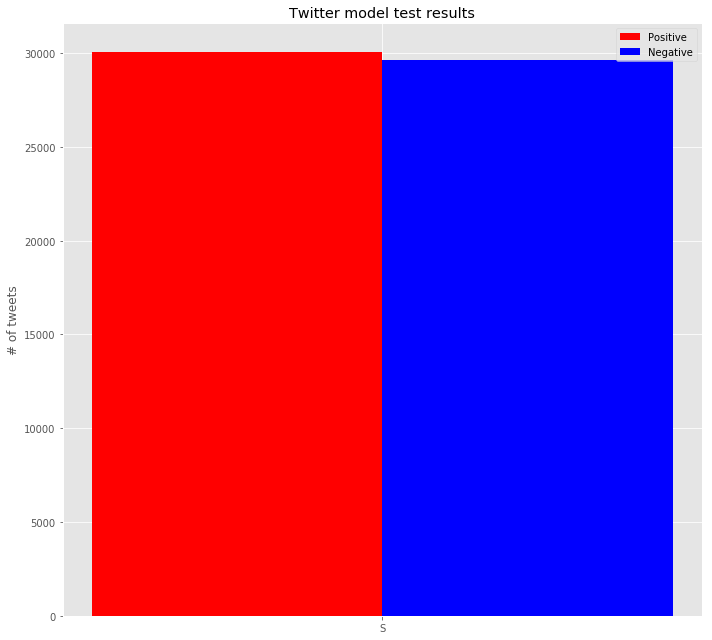

In [36]:
import np
import matplotlib.pyplot as plt

N = 1
total_pos = (30083)
#men_std = (2, 3)

ind = np.arange(N)  # the x locations for the groups
width = 0.15       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, total_pos, width, color='r', yerr=0)

total_neg = (29660)
#women_std = (3, 5)
rects2 = ax.bar(ind + width, total_neg, width, color='b', yerr=0)

# add some text for labels, title and axes ticks
ax.set_ylabel('# of tweets')
ax.set_title('Twitter model test results')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('S'))

ax.legend((rects1[0], rects2[0]), ('Positive', 'Negative'))

plt.tight_layout()

plt.show()

plt.savefig('twitterplot.png')

NameError: name 'models' is not defined

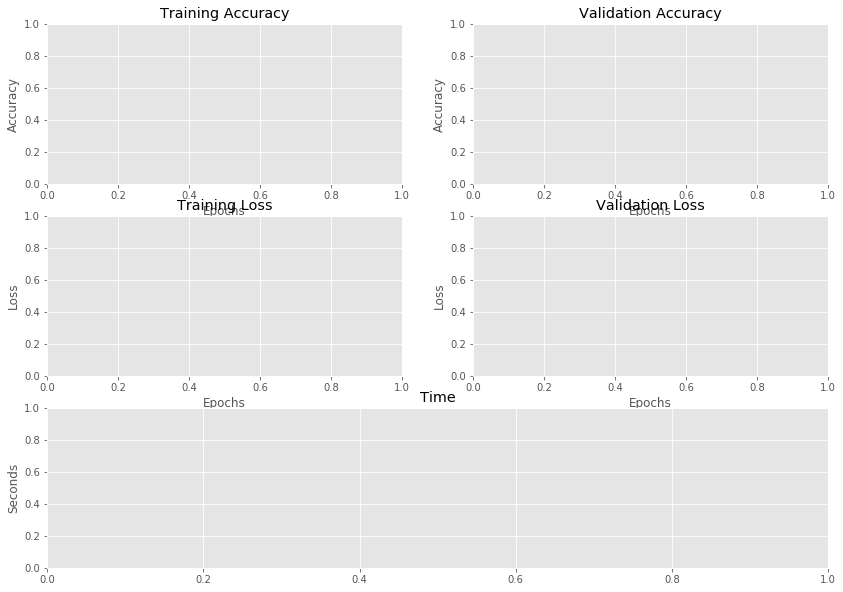

In [35]:

plt.style.use('ggplot')
plt.figure(figsize=(14, 10))#, dpi=100)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.set_title('Training Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.set_title('Training Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax3 = plt.subplot2grid((3, 2), (0, 1))
ax3.set_title('Validation Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epochs')

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.set_title('Validation Loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epochs')

ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2)
ax5.set_title('Time')
ax5.set_ylabel('Seconds')

for mode, result in zip(models, results):
    ax1.plot(result[0].epoch, result[0].history['acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['loss'], label=mode)
    ax3.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax4.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
    
ax1.legend()
ax2.legend()

ax3.legend()
ax4.legend()

ax5.bar(np.arange(len(results)), [x[1] for x in results], tick_label = models.keys(), align='center')

plt.tight_layout()
plt.show()